# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-03-26 11:40:36.650114


In [2]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [3]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)

In [4]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
import seaborn as sns

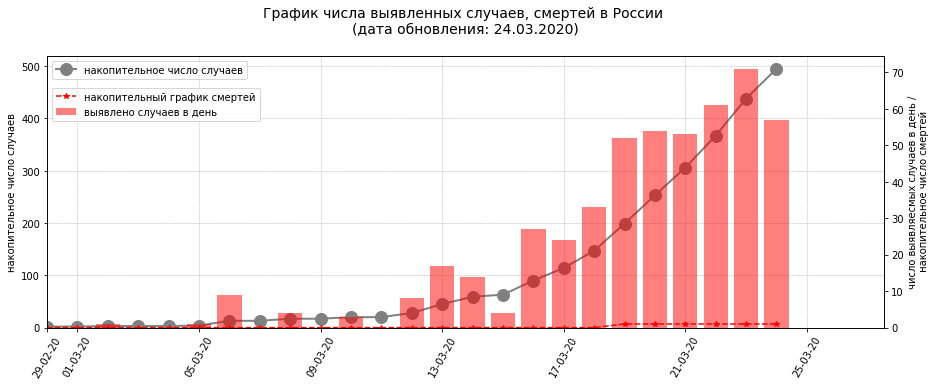

In [5]:
log = False # set True for log scale

start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases'], color='grey', marker='o', linewidth=2, markersize=12)
if log == True: ax1.set_yscale('log')
    
ax2 = ax1.twinx()
ax2.plot(russian_data['deaths'], color='red', marker='*', linestyle='--')

cases_a_day = russian_data['cases'] - russian_data['cases'].shift(1).fillna(0)
ax2.bar(x=cases_a_day.index, height=cases_a_day, color='red', alpha=0.5)

if log == True: ax2.set_yscale('log')

title = '''График числа выявленных случаев, смертей в России {}
(дата обновления: {:%d.%m.%Y})
'''.format(''.join(['(логарифмическая шкала)' if log else '']), cases_a_day.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax1.set_ylim(0)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день'], 
               loc='upper left', bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.show()

# Ситуация по регионам России

Для визуализации используются открытые данные Роспотребнадзора и других органов, собранные в одну таблицу силами активистов. (Спасибо Софии!)

In [6]:
from io import BytesIO
import requests
import geopandas as gpd

In [7]:
# Границы регионов с OSM
russian_border = gpd.read_file('admin_level_2.geojson')
subjects_borders = gpd.read_file('admin_level_4.geojson')

subjects_borders = subjects_borders.to_crs('epsg:3857')
russian_border = russian_border.to_crs('epsg:3857')

In [8]:
google_sheet = 'https://docs.google.com/spreadsheets/d/1ZdNZtCBp7yp6-KwuUHB0bd-VN6VbKwRilC6ZX_jwtFE/export?gid=0&format=csv'
raw_data = requests.get(google_sheet).content
russian_regions = pd.read_csv(BytesIO(raw_data), index_col=0,
                             parse_dates=['Дата обновления'],
                             dayfirst=True).set_index('Дата обновления')
russian_regions.columns = [column.replace(' Республика', ' республика') for column in russian_regions.columns]

def correct_region_names(item):
    if item == 'Республика Татарстан':
        return 'Татарстан'
    elif item == 'Кабардино-Балкарская республика':
        return 'Кабардино-Балкария'
    elif item in ['Удмурсткая республика', 'Удмуртская республика']:
        return 'Удмуртия'
    elif item == 'Чувашская республика':
        return 'Чувашия'
    elif item == 'Ханты-Мансийский АО':
        return 'Ханты-Мансийский автономный округ - Югра'
    elif item == 'Республика Башкортостан':
        return 'Башкортостан'
    else:
        return item

russian_regions.columns = [correct_region_names(item) for item in russian_regions.columns]

In [9]:
region_start_index = russian_regions.columns.tolist().index('Тестов сделано')+1
region_list = russian_regions.columns.tolist()[region_start_index:]
region_list.remove('Сумма по регионам')

for item in region_list: # чек, что все имена субъектов корректны
    if item not in subjects_borders['name'].unique():
        print(item)

Сумма по регионам отличается от статистики заражений за все время


In [10]:
last_update = russian_regions.iloc[[-1]][region_list].T
update_date = last_update.columns[0]
last_update = last_update.rename(columns={update_date: 'corona_cases'})


subjects_borders = subjects_borders.merge(last_update, left_on='name', right_index=True, how='left')
subjects_borders['corona_cases'] = subjects_borders['corona_cases'].fillna(0)

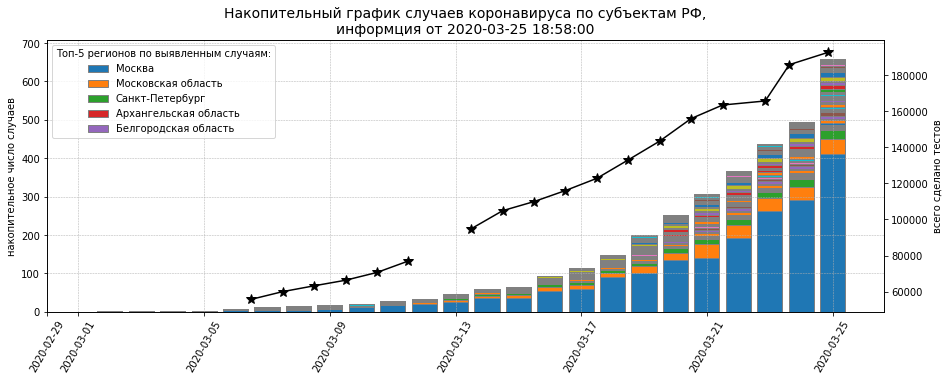

In [11]:
ordered_regions = russian_regions[region_list].max().index
bottom = np.array([0] * russian_regions.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15,5))

for region in ordered_regions:
    plt.bar(x=russian_regions.index.date, 
            height=russian_regions[region].fillna(0).values, 
            bottom=bottom, edgecolor='gray')
    bottom = bottom + russian_regions[region].fillna(0).values
ax.grid(linestyle='--', linewidth=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.xticks(rotation=60)
plt.title('''Накопительный график случаев коронавируса по субъектам РФ,
информция от {}'''.format(update_date), fontsize=14)
plt.legend(ordered_regions[:5], title="Топ-5 регионов по выявленным случаям:")
ax.set_ylabel('накопительное число случаев')
ax.set_xlim(start_date)
ax.set_ylim(0, russian_regions['Сумма по регионам'].max()+50)

ax_test = ax.twinx()
ax_test.plot(russian_regions['Тестов сделано'], marker='*', markersize=10, color='black')
ax_test.set_ylabel('всего сделано тестов')
plt.show()

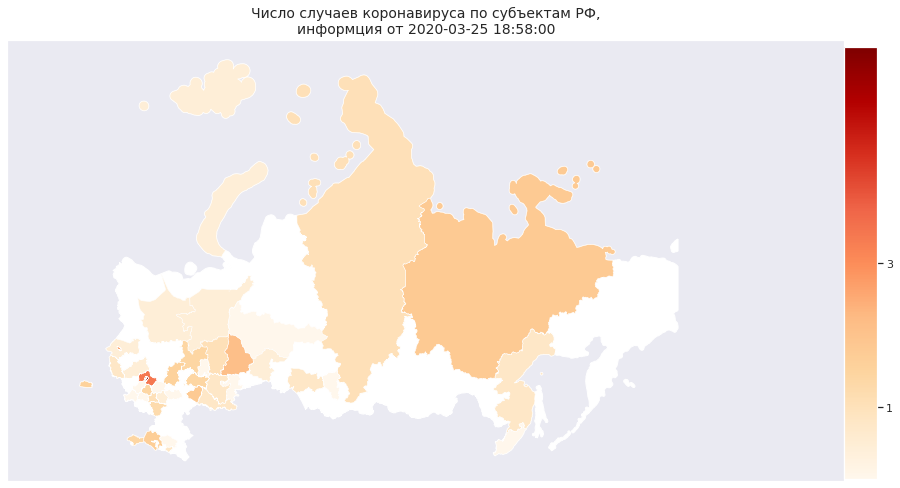

In [12]:
subjects_borders['corona_cases_log'] = subjects_borders['corona_cases'].apply(lambda x: np.log(x) if x > 0 else x)

sns.set_style('darkgrid')
sns.set_context('notebook')

plt.rcParams['figure.figsize'] = (15, 15)
ax = russian_border.plot(color='white')
cmap = 'OrRd'
subjects_borders.query('corona_cases_log > 0').plot(ax=ax, column='corona_cases_log', linewidth=0.5, cmap=cmap)
ax.set_xlim([0, ax.get_xticks().max()])
ax.set(xticklabels=[], yticklabels=[])
ax.grid(False)
plt.title('''Число случаев коронавируса по субъектам РФ,
информция от {}'''.format(update_date), fontsize=14)

fig = ax.get_figure()
vmin, vmax = round(subjects_borders['corona_cases_log'].min()), round(subjects_borders['corona_cases_log'].max())
cax = fig.add_axes([0.9, 0.3, 0.03, 0.4])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
clrbar = fig.colorbar(sm, cax=cax)
clrbar.set_ticks([round(item) for item in np.exp(clrbar.get_ticks())])
plt.show()